<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In [ ]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
!unzip -j 2-ab.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

--2024-10-21 07:43:06--  https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip [following]
--2024-10-21 07:43:07--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423991 (13M) [application/zip]
Saving to: ‘2-ab.zip’

2-ab.zip            100%[===================>]  12.80M  --.-KB/s    in 0.1s    

2024-10-21 07:43:07 (108 MB/s) - ‘2-ab.zip’ saved [13423991/13423991]

Archive:  2-ab.zip
  inflating: ._2-ab            

In [ ]:
import math
import torch
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%run 'utils-data.py'
from IPython.display import clear_output

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import math
import torch
import numpy as np
import scipy.io

class CirclesData:

    def __init__(self):
        # Grid
        x1,x2 = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
        self._Xgrid = np.array([x1.flatten(), x2.flatten()]).T.astype('float32')

        # Real data
        circles = scipy.io.loadmat("circles.mat")
        self._Xtrain, self._Xtest, self._Ytrain, self._Ytest = circles["Xtrain"].astype('float32'), circles["Xtest"].astype('float32'), circles["Ytrain"].astype('float32'), circles["Ytest"].astype('float32')

        self._Xgrid_th = torch.from_numpy(self._Xgrid)
        self._Xtrain_th = torch.from_numpy(self._Xtrain)
        self._Xtest_th = torch.from_numpy(self._Xtest)
        self._Ytrain_th = torch.from_numpy(self._Ytrain)
        self._Ytest_th = torch.from_numpy(self._Ytest)

        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []

    def __getattr__(self, key):
        if key == "Xgrid": return self._Xgrid_th
        if key == "Xtrain": return self._Xtrain_th
        if key == "Xtest": return self._Xtest_th
        if key == "Ytrain": return self._Ytrain_th
        if key == "Ytest": return self._Ytest_th
        return None

    def plot_data(self):
        plt.figure(1, figsize=(5,5))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0], self._Xtrain[self._Ytrain[:,0] == 1,1], 'bo', label="Train")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0], self._Xtrain[self._Ytrain[:,1] == 1,1], 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0], self._Xtest[self._Ytest[:,0] == 1,1], 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0], self._Xtest[self._Ytest[:,1] == 1,1], 'r+')
        plt.legend()
        plt.show()

    def plot_data_with_grid(self, Ygrid, title=""):
        plt.figure(2)
        Ygrid = Ygrid[:,1].numpy()
        plt.clf()
        plt.imshow(np.reshape(Ygrid, (40,40)))
        plt.plot(self._Xtrain[self._Ytrain[:,0] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
        plt.plot(self._Xtrain[self._Ytrain[:,1] == 1,0]*10+20, self._Xtrain[self._Ytrain[:,1] == 1,1]*10+20, 'ro')
        plt.plot(self._Xtest[self._Ytest[:,0] == 1,0]*10+20, self._Xtest[self._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
        plt.plot(self._Xtest[self._Ytest[:,1] == 1,0]*10+20, self._Xtest[self._Ytest[:,1] == 1,1]*10+20, 'r+')
        plt.xlim(0,39)
        plt.ylim(0,39)
        plt.clim(0.3,0.7)
        plt.title(title)
        plt.draw()
        plt.pause(1e-3)

    def plot_loss(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        plt.figure(3)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.array(self.acc_train), label="acc. train")
        plt.plot(np.array(self.acc_test), label="acc. test")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(self.loss_train), label="loss train")
        plt.plot(np.array(self.loss_test), label="loss test")
        plt.legend()
        plt.show()

class MNISTData:

    def __init__(self):
        # Real data
        mnist = scipy.io.loadmat("mnist.mat")
        self._Xtrain_th = torch.from_numpy(mnist["Xtrain"].astype('float32'))
        self._Xtest_th = torch.from_numpy(mnist["Xtest"].astype('float32'))
        self._Ytrain_th = torch.from_numpy(mnist["Ytrain"].astype('float32'))
        self._Ytest_th = torch.from_numpy(mnist["Ytest"].astype('float32'))

    def __getattr__(self, key):
        if key == "Xtrain": return self._Xtrain_th
        if key == "Xtest": return self._Xtest_th
        if key == "Ytrain": return self._Ytrain_th
        if key == "Ytest": return self._Ytest_th
        return None

# Part 1 : Forward and backward passes "by hands"

Question 2


In [ ]:
def init_params(nx=2, nh=3, ny=3):      #n of neuron
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    params["Wh"] = torch.randn((nx, nh)) * 0.01
    params["Wy"] = torch.randn((nh, ny)) * 0.01

    #bias with 0
    params["bh"] = torch.zeros((1,nh))  # (nh, 1)
    params["by"] = torch.zeros((1,ny))  # (ny, 1)


    ####################
    ##      END        #
    ####################
    return params

**$$Question 3$$**
### Hidden Layer and Output Layer Transformation

In a neural network, both the hidden layer and the output layer perform an **affine transformation** followed by an optional activation function. This process helps the model learn complex patterns and produce predictions.

#### Steps to Compute $ \tilde{h} $, $ h $, $ \tilde{y} $, and $ \hat{y} $:

### 1. Hidden Layer Transformation:

1. **Affine Transformation for $ \tilde{h} $**:
   - The input to the hidden layer is represented as a matrix $ X $ of size $ (n\_batch, nx) $, where:
     - $ n\_batch $ is the number of samples in the batch.
     - $ nx $ is the number of input features for each sample.
     
   - The hidden layer has:
     - A **weight matrix** $ W_h $ of size $ (nh, nx) $, where:
       - $ nh $ is the number of hidden neurons.
       - Each row in $ W_h $ corresponds to the weights associated with one hidden neuron.
     - A **bias vector** $ b_h $ of size $ (nh) $, where each element corresponds to a bias term for each hidden neuron.

   The affine transformation is computed as:
   $$
   \tilde{h} = X \cdot W_h^T + b_h
   $$
   - $ X \cdot W_h^T $: This is the matrix multiplication between the input $ X $ (of size $ (n\_batch, nx) $) and the **transpose** of $ W_h $ (of size $ (nx, nh) $), which results in a matrix $ \tilde{h} $ of size $ (n\_batch, nh) $.
   - $ b_h $: The bias vector $ b_h $ is added to each row of the result, broadcasted across the batch dimension.

2. **Activation Function for $ h $**:
   - After the affine transformation, a **non-linear activation function** like `tanh` is applied to $ \tilde{h} $:
   $$
   h = \text{tanh}(\tilde{h})
   $$
   This ensures the network can learn non-linear relationships.

### 2. Output Layer Transformation:

After computing the hidden layer output $ h $, the output layer produces the final predictions:

1. **Affine Transformation for $ \tilde{y} $**:
   - The output layer takes the hidden layer activations $ h $ (of size $ (n\_batch, nh) $) and applies another affine transformation to produce $ \tilde{y} $, the pre-activation output of the network.
   - The output layer has:
     - A **weight matrix** $ W_y $ of size $ (ny, nh) $, where:
       - $ ny $ is the number of output neurons (typically corresponding to the number of classes in classification tasks).
     - A **bias vector** $ b_y $ of size $ (ny) $.

   The affine transformation for the output layer is computed as:
   $$
   \tilde{y} = h \cdot W_y^T + b_y
   $$
   - $ h \cdot W_y^T $: This is the matrix multiplication between the hidden layer output $ h $ (of size $ (n\_batch, nh) $) and the **transpose** of $ W_y $ (of size $ (ny, nh) $), resulting in $ \tilde{y} $ of size $ (n\_batch, ny) $.
   - $ b_y $: The bias vector $ b_y $ is added to each row of the result.

2. **Softmax Function for $ \hat{y} $**:
   - After computing $ \tilde{y} $, the network applies the **softmax function** to convert the pre-activations into probabilities. The softmax function ensures that the output values are positive and sum to 1, making them valid probability distributions.
   $$
   \hat{y} = \frac{\exp(\tilde{y})}{\sum \exp(\tilde{y})}
   $$
   - The exponential function $ \exp(\tilde{y}) $ is applied element-wise to $ \tilde{y} $, and the result is normalized by the sum of exponentials across the output dimension.

### Summary of Transformations:
1. **Hidden Layer**:
   - Affine transformation: $ \tilde{h} = X \cdot W_h^T + b_h $
   - Non-linear activation: $ h = \text{tanh}(\tilde{h}) $
   
2. **Output Layer**:
   - Affine transformation: $ \tilde{y} = h \cdot W_y^T + b_y $
   - Softmax function: $ \hat{y} = \frac{\exp(\tilde{y})}{\sum \exp(\tilde{y})} $

The final output $ \hat{y} $ represents the network's predicted probabilities for each class.


In [ ]:

def forward(params, X):
    bsize = X.size(0)  # batch size
    nh = params['Wh'].size(0)  # hidden layer size
    ny = params['Wy'].size(0)  # output layer size

    outputs = {}
    outputs["X"] = X
    outputs["htilde"] = torch.mm(X, params['Wh']) + params['bh']  # Moltiplicazione corretta
    outputs["h"] = torch.tanh(outputs["htilde"])  # Funzione di attivazione
    outputs["ytilde"] = torch.mm(outputs["h"], params['Wy']) + params['by']  # Moltiplicazione corretta
    outputs["yhat"] = torch.exp(outputs["ytilde"]) / torch.sum(torch.exp(outputs["ytilde"]), dim=1, keepdim=True)  # Softmax
    return outputs['yhat'], outputs


params = init_params(2,3,3)
# X = torch.tensor([[2.0,3.0],[1.0, 2.0]])
# forward(params, X)


Question 4 We use the $$ \text{Cross-entropy} = - \sum_{i=1}^{ny} Y_i \cdot \log(\hat{Y}_i) $$


In [ ]:
def loss_accuracy(Yhat, Y):

    #####################
    ## Your code here  ##
    #####################
  size_examp = Yhat.size(dim = 0)
  L = - (Y * torch.log((Yhat))).sum(axis = 1).mean()
  _, indsY = torch.max(Y, 1)
  _, indsYhat = torch.max(Yhat, 1)
  acc = torch.where((indsY == indsYhat), 1, 0).sum() / size_examp * 100

    ####################
    ##      END        #
    ####################

  return L, acc

$$Question 5$$


In [ ]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wy, Wh, by, bh


    grad_ytilde = outputs['yhat'] - Y
    grad_htilde = torch.mm(grad_ytilde, params['Wy'].T) * (1 - outputs['h']**2)

    grads["Wy"] = torch.mm(grad_ytilde.T, outputs['h']).T
    grads["Wh"] = torch.mm(grad_htilde.T, outputs['X']).T
    grads["by"] = grad_ytilde.sum(axis=0)
    grads["bh"] = grad_htilde.sum(axis=0)


    ####################
    ##      END        #
    ####################
    return grads

Question 6

In [ ]:
def sgd(params, grads, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the params values
    params["Wh"] -= grads["Wh"] * eta
    params["Wy"] -= grads["Wy"] * eta
    # print(f"Wh shape: {params['Wh'].shape}, grads Wh shape: {grads['Wh'].shape}")
    # print(f"Wy shape: {params['Wy'].shape}, grads Wy shape: {grads['Wy'].shape}")
    params["bh"] -= grads["bh"] * eta
    params["by"] -= grads["by"] * eta



    ####################
    ##      END        #
    ####################
    return params

Prima parte fatta

## Global learning procedure "by hands"

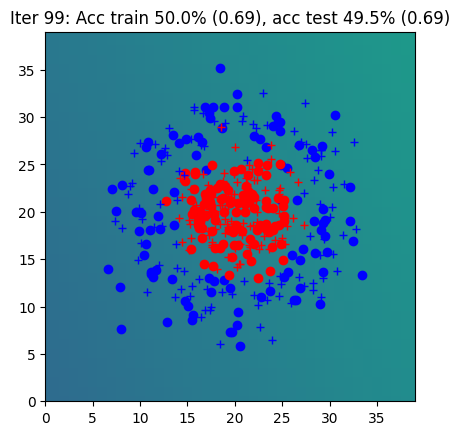

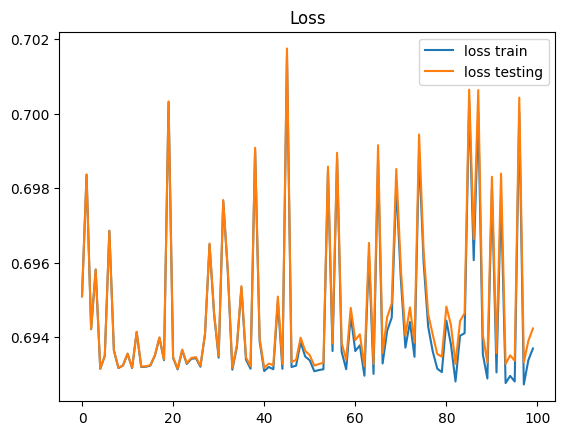

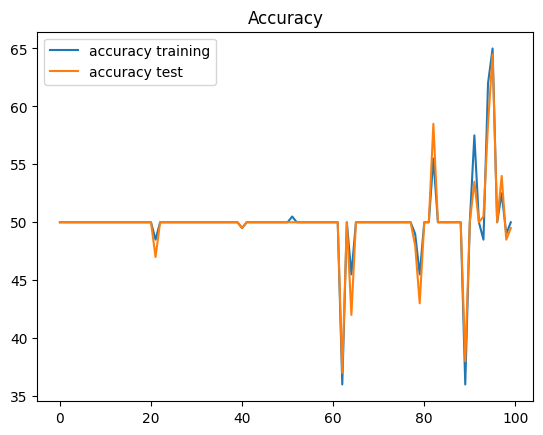

<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython.display import clear_output
# from utils-data import CirclesData
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(100):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd

        #forward
        Yhat, outputs = forward(params, X)

        #calculate the loss
        L, accur = loss_accuracy(Yhat, Y)

        #backward pass

        grads = backward(params, outputs, Y )

        #steps sgd
        params = sgd(params, grads, eta)

    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    clear_output(wait = True)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

    #init

fig_loss= plt.figure()
fig_accuracy = plt.figure()

ax_1 = fig_loss.add_subplot(111)
ax_2 = fig_accuracy.add_subplot(111)

# ax_1 = fig_loss = plt.figure(111)
# ax_2 = fig_accurancy.add_subplot(111)

#plotting the two losses

fig = plt.figure()
ax_1.plot(curves[2], label="loss train")  # Cambiato da 02 a 2
ax_1.plot(curves[3], label="loss testing")  # Cambiato da 03 a 3
ax_1.set_title("Loss")
ax_1.legend()

#plotting the accuracy
ax_2.plot(curves[0], label="accuracy training")  # corretto spelling accurancy -> accuracy
ax_2.plot(curves[1], label="accuracy test")
ax_2.set_title("Accuracy")
ax_2.legend()

plt.show()




Influence of the learning rate and the batch size da cambiare un pochino

In [ ]:
def optimize_learning_rates(learning_rates):    #COPIATO
    loss_data = {}
    accuracy_data = {}

    for eta in learning_rates:
        params = init_params(nx, nh, ny)

        curves = [[], [], [], []]

        # epoch
        for iteration in range(150):
            # permute
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            # batches
            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j+1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch]

                # write the optimization algorithm on the batch (X,Y)
                # using the functions: forward, loss_accuracy, backward, sgd

                # forward pass
                Yhat, outputs = forward(params, X)

                # calculate the loss
                L, acc = loss_accuracy(Yhat, Y)

                # backward pass
                grads = backward(params, outputs, Y)

                # step through sgd
                params = sgd(params, grads, eta)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            # Store the loss and accuracy data for the current learning rate
            if eta not in loss_data:
                loss_data[eta] = []
                accuracy_data[eta] = []

            loss_data[eta].append(Ltest)
            accuracy_data[eta].append(acctest)

        # Plot the results for the current learning rate
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Loss (Learning Rate: {eta})")
        for lr, losses in loss_data.items():
            plt.plot(losses, label=f"LR: {lr}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Accuracy (Learning Rate: {eta})")
        for lr, accs in accuracy_data.items():
            plt.plot(accs, label=f"LR: {lr}")
        plt.legend()

        plt.show()

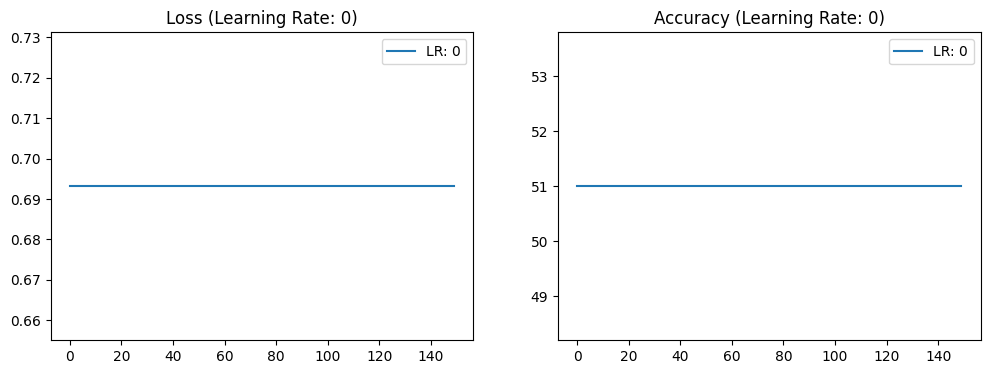

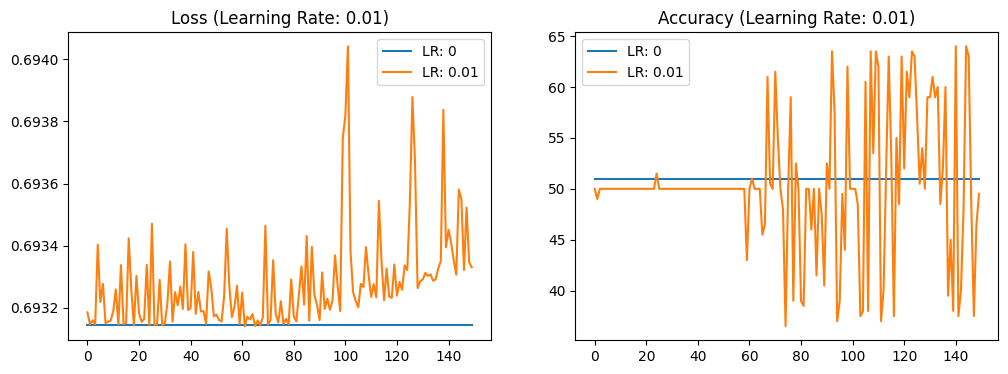

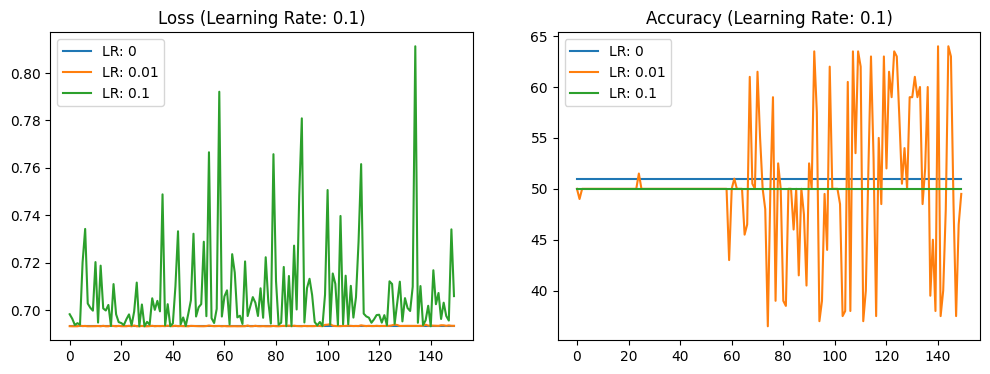

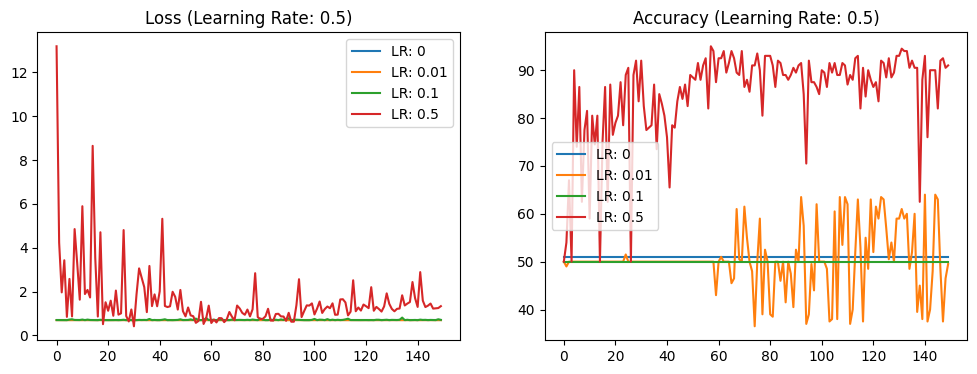

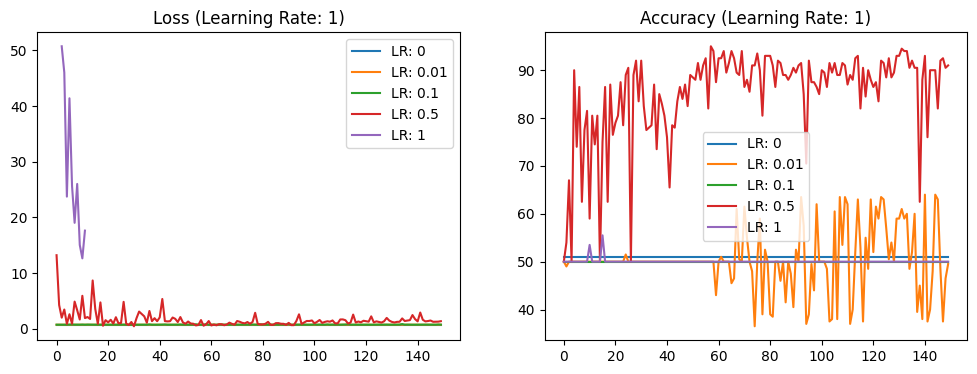

In [ ]:
# List of learning rates to experiment with   #COPIATO
learning_rates = [0,0.01, 0.1, 0.5,1]

# Call the optimization function
optimize_learning_rates(learning_rates)

In [ ]:
def optimize_batch_sizes(batch_sizes):    #COPIATO
    loss_data = {}
    accuracy_data = {}

    for Nbatch in batch_sizes:
        params = init_params(nx, nh, ny)

        curves = [[], [], [], []]

        # epoch
        for iteration in range(150):
            # permute
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            # batches
            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j+1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch]

                # write the optimization algorithm on the batch (X,Y)
                # using the functions: forward, loss_accuracy, backward, sgd

                # forward pass
                Yhat, outputs = forward(params, X)

                # calculate the loss
                L, acc = loss_accuracy(Yhat, Y)

                # backward pass
                grads = backward(params, outputs, Y)

                # step through sgd
                params = sgd(params, grads, eta)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            # Store the loss and accuracy data for the current batch size
            if Nbatch not in loss_data:
                loss_data[Nbatch] = []
                accuracy_data[Nbatch] = []

            loss_data[Nbatch].append(Ltest)
            accuracy_data[Nbatch].append(acctest)

        # Plot the results for the current batch size
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Loss (Batch Size: {Nbatch})")
        for bs, losses in loss_data.items():
            plt.plot(losses, label=f"Batch Size: {bs}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Accuracy (Batch Size: {Nbatch})")
        for bs, accs in accuracy_data.items():
            plt.plot(accs, label=f"Batch Size: {bs}")
        plt.legend()

        plt.show()

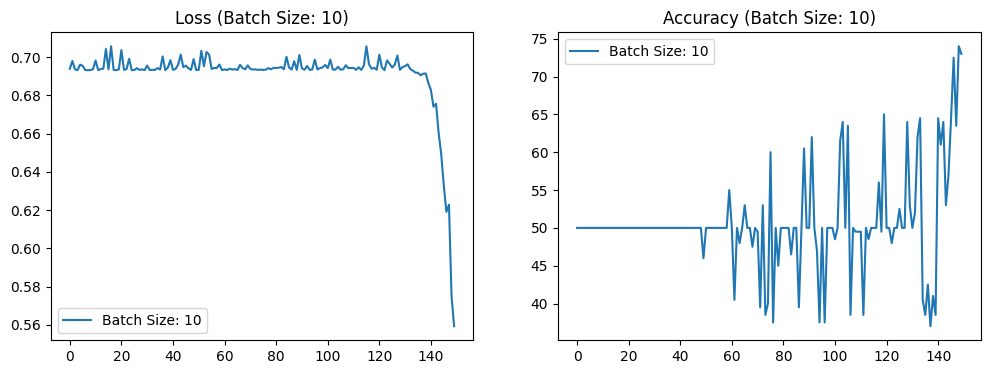

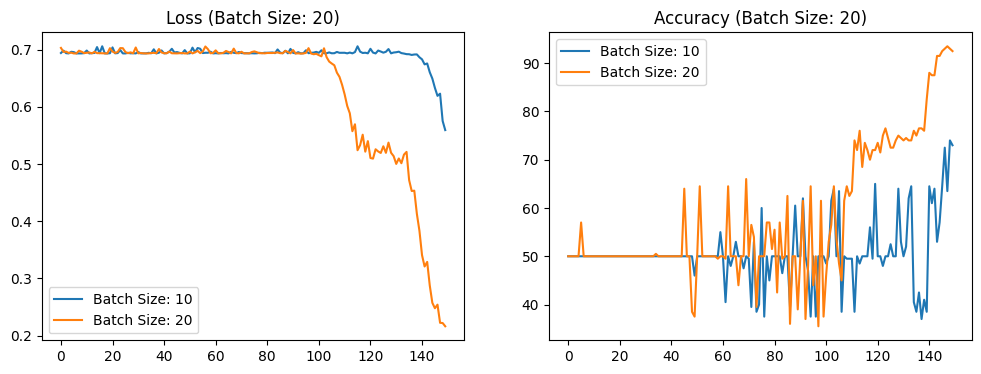

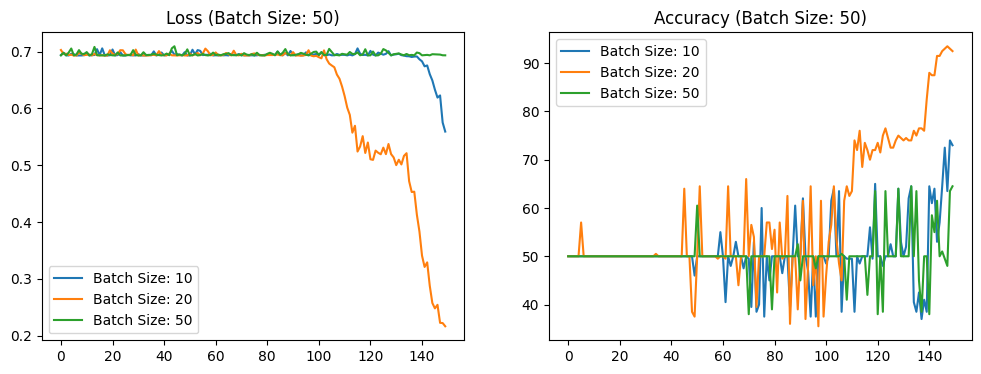

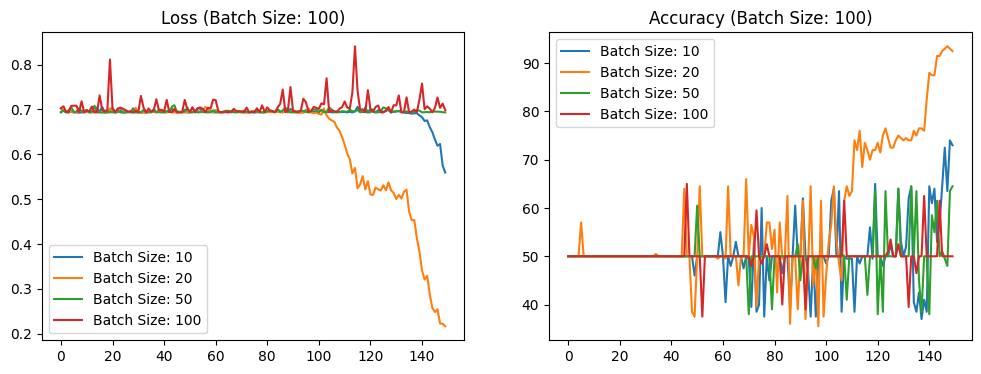

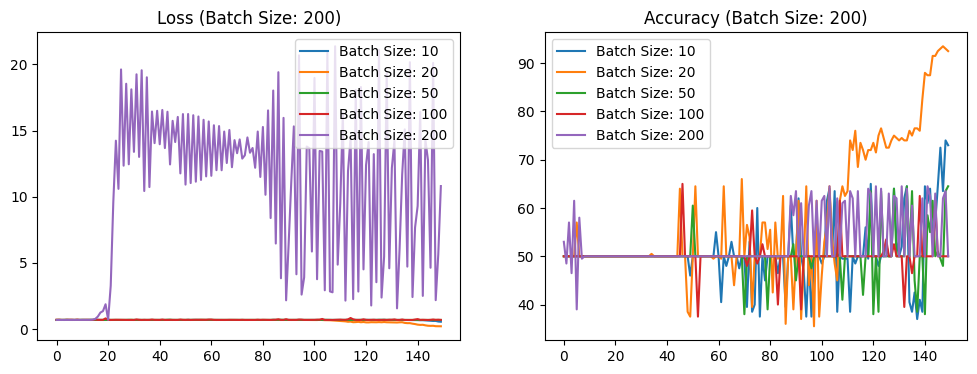

In [ ]:
batch_sizes = [10, 20, 50, 100,200] #COPIATO

# Call the optimization function
optimize_batch_sizes(batch_sizes)

# Part 2 : Simplification of the backward pass with `torch.autograd`



In [ ]:
def init_params(nx, nh, ny):    #prof
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    # activaye autograd on the network weights

    params["Wh"] = torch.randn(size=(nx, nh), requires_grad=True)
    params["Wy"] = torch.randn(size=(nh, ny), requires_grad=True)

    params["bh"] = torch.randn(size=(1, nh), requires_grad=True)
    params["by"] = torch.randn(size=(1, ny), requires_grad=True)

    ####################
    ##      END        #
    ####################
    return params

The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [ ]:
def sgd(params, eta):   #prof

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():
      params["Wh"] -= params['Wh'].grad * eta
      params["bh"] -= params['bh'].grad * eta
      params["Wy"] -= params['Wy'].grad * eta
      params["by"] -= params['by'].grad * eta

    params['Wh'].grad.zero_()
    params['bh'].grad.zero_()
    params['Wy'].grad.zero_()
    params['by'].grad.zero_()

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure with autograd  

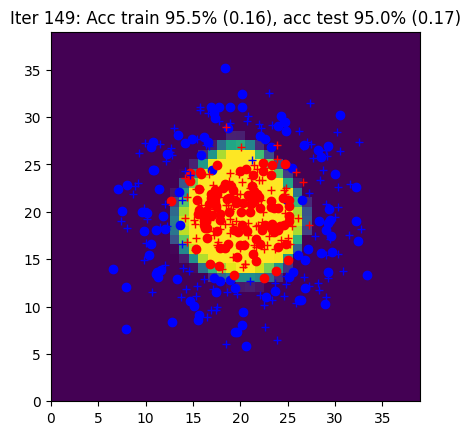

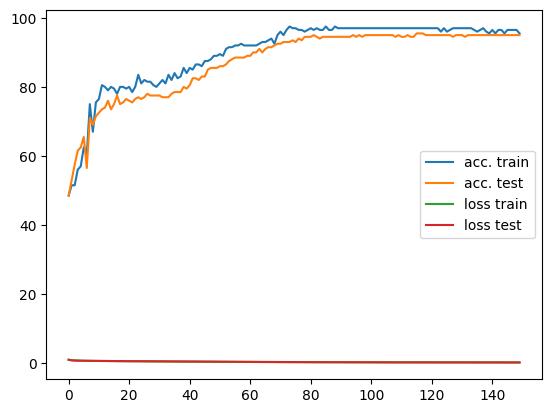

In [ ]:
# init
data = CirclesData()      #prof
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd

        Yhat, outputs = forward(params, X)
        L, _ = loss_accuracy(Yhat, Y)
        L.backward()
        params = sgd(params, eta)
    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    clear_output(wait=True)
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

In [ ]:
def optimize_learning_rates(learning_rates):      #prof
    loss_data = {}
    accuracy_data = {}

    for eta in learning_rates:
        params = init_params(nx, nh, ny)

        curves = [[], [], [], []]

        # epoch
        for iteration in range(150):
            # permute
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            # batches
            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j+1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch, :]

                # write the optimization algorithm on the batch (X,Y)
                # using the functions: forward, loss_accuracy, backward, sgd
                Yhat, outputs = forward(params, X)
                L, _ = loss_accuracy(Yhat, Y)
                L.backward()
                params = sgd(params, eta)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            # Store the loss and accuracy data for the current learning rate
            if eta not in loss_data:
                loss_data[eta] = []
                accuracy_data[eta] = []

            loss_data[eta].append(Ltest.detach().numpy())
            accuracy_data[eta].append(acctest)

        # Plot the results for the current learning rate
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Loss (Learning Rate: {eta})")
        for lr, losses in loss_data.items():
            plt.plot(losses, label=f"Learning Rate: {lr}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Accuracy (Learning Rate: {eta})")
        for lr, accs in accuracy_data.items():
            plt.plot(accs, label=f"Learning Rate: {lr}")
        plt.legend()

        plt.tight_layout()


        plt.show()

In [ ]:
def optimize_batch_sizes(batch_sizes):      #prof
    loss_data = {}
    accuracy_data = {}

    for Nbatch in batch_sizes:
        params = init_params(nx, nh, ny)

        curves = [[], [], [], []]

        # epoch
        for iteration in range(150):
            # permute
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            # batches
            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j+1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch]

                # write the optimization algorithm on the batch (X,Y)
                # using the functions: forward, loss_accuracy, backward, sgd
                Yhat, outputs = forward(params, X)
                L, _ = loss_accuracy(Yhat, Y)
                L.backward()
                params = sgd(params, eta)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            # Store the loss and accuracy data for the current batch size
            if Nbatch not in loss_data:
                loss_data[Nbatch] = []
                accuracy_data[Nbatch] = []

            loss_data[Nbatch].append(Ltest.detach().numpy())
            accuracy_data[Nbatch].append(acctest)

        # Plot the results for the current batch size
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Loss (Batch Size: {Nbatch})")
        for bs, losses in loss_data.items():
            plt.plot(losses, label=f"Batch Size: {bs}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Accuracy (Batch Size: {Nbatch})")
        for bs, accs in accuracy_data.items():
            plt.plot(accs, label=f"Batch Size: {bs}")
        plt.legend()

        plt.tight_layout()

        plt.show()

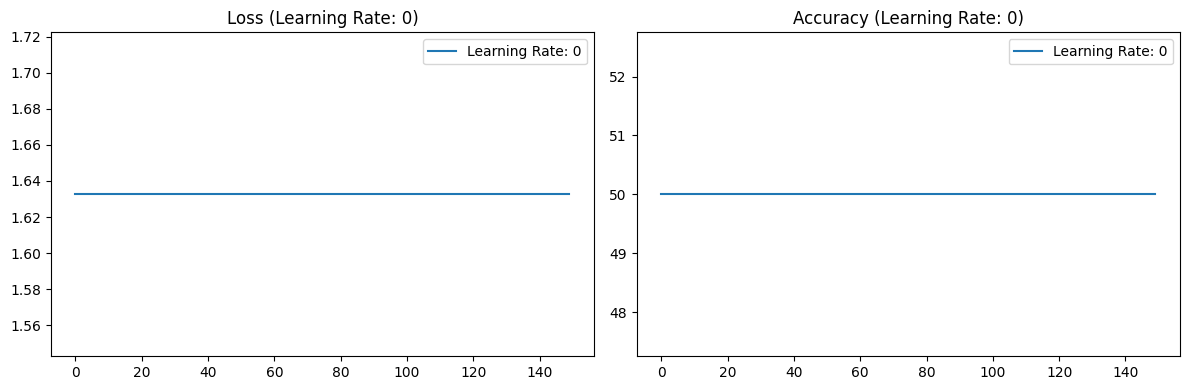

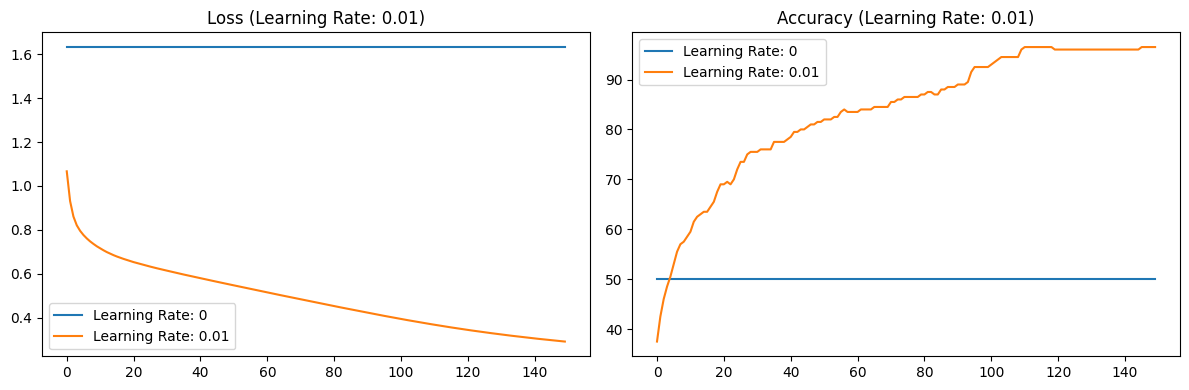

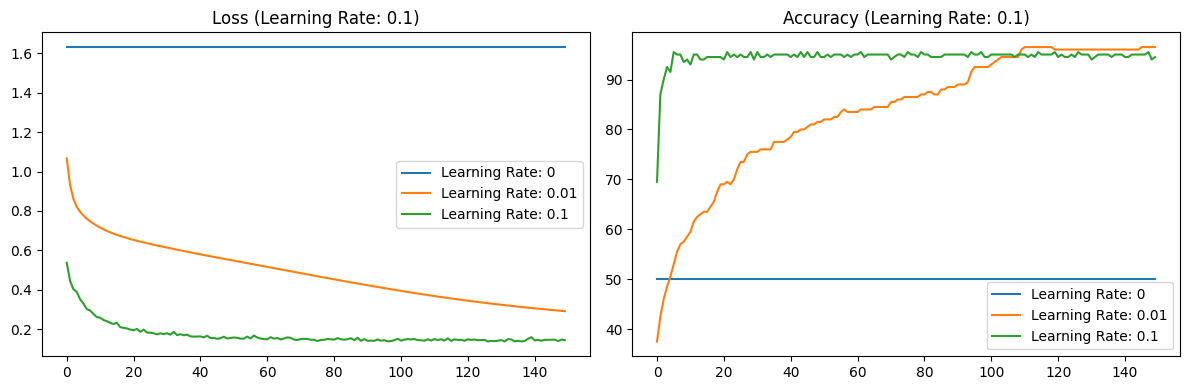

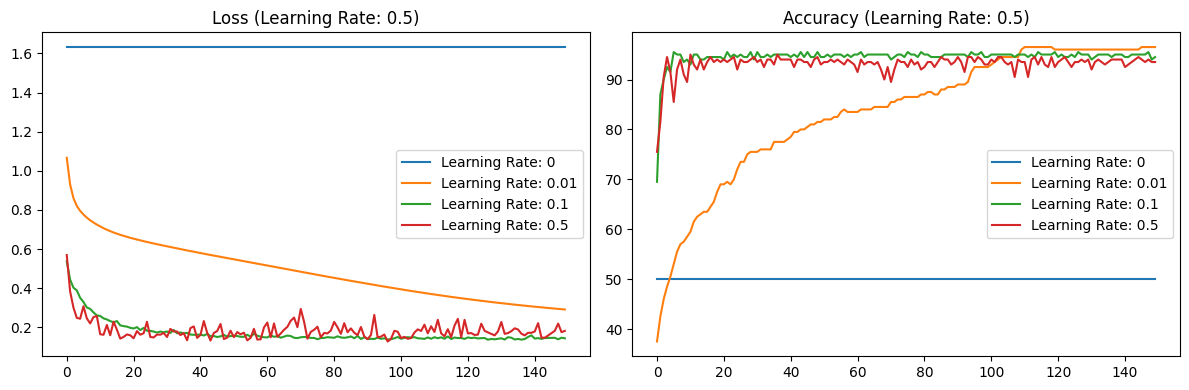

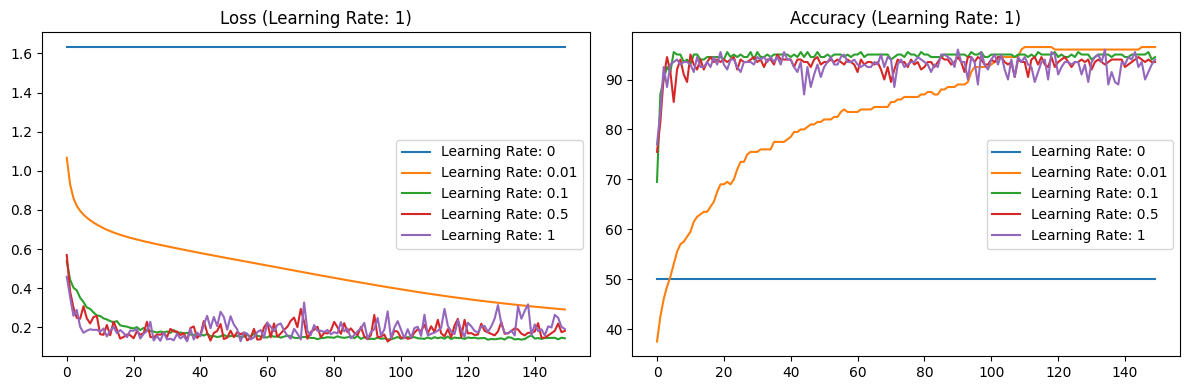

In [ ]:
learning_rates = [0,0.01, 0.1, 0.5,1]

# Call the optimization function
optimize_learning_rates(learning_rates)

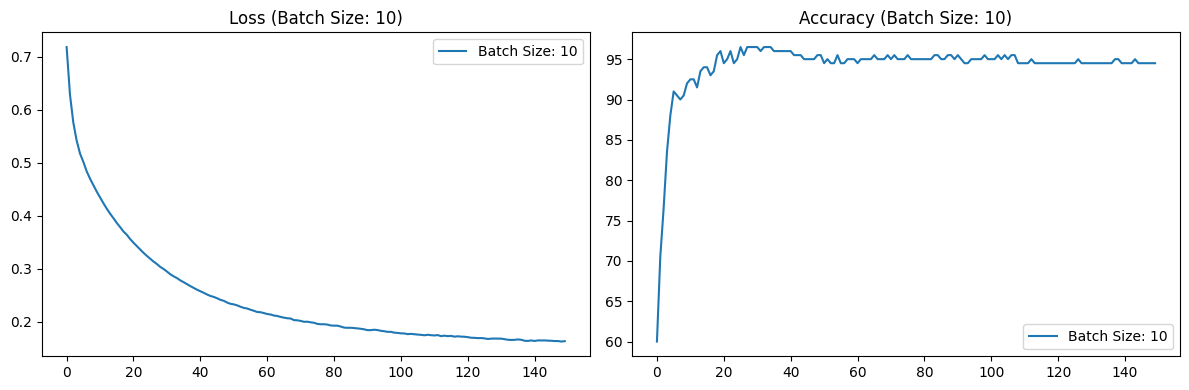

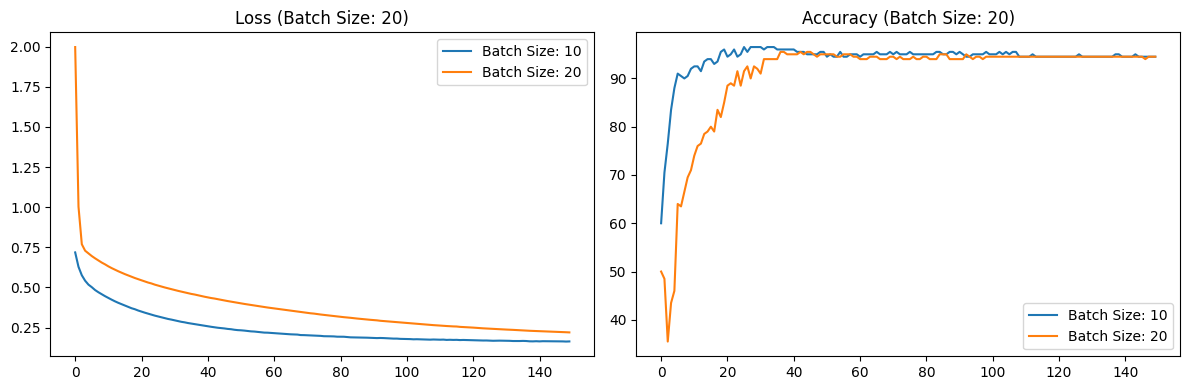

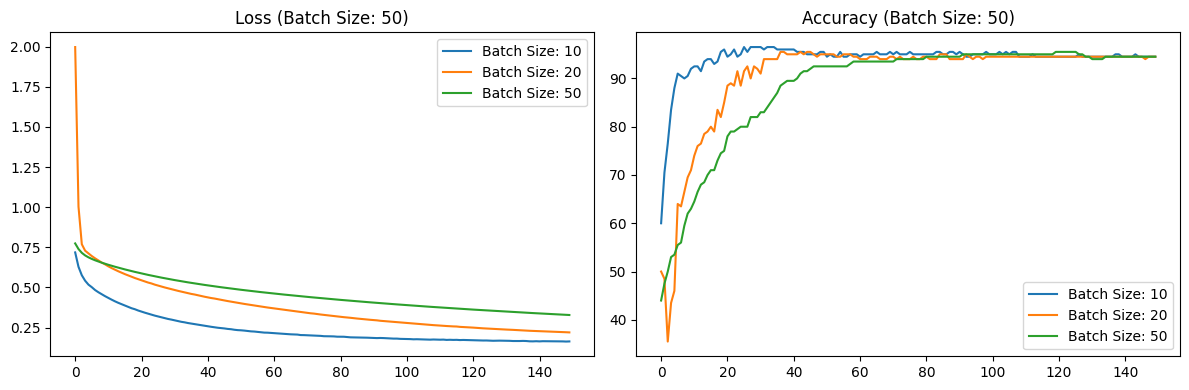

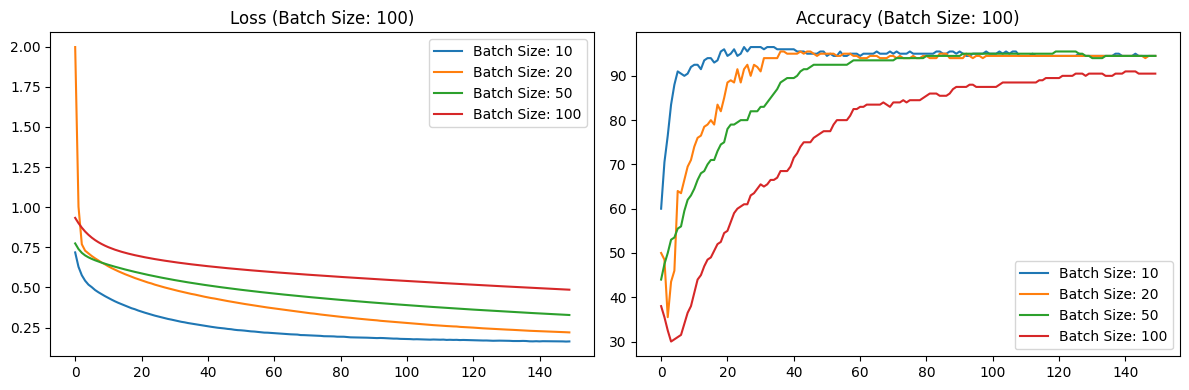

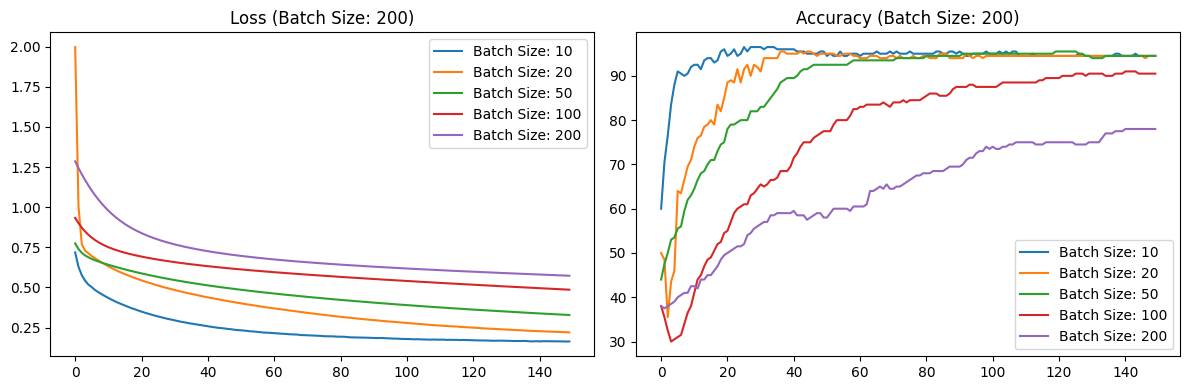

In [ ]:
batch_sizes = [10, 20, 50, 100,200]

# Call the optimization function
optimize_batch_sizes(batch_sizes)

influence of the leraning rate and the batch size


# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [ ]:
def init_model(nx, nh, ny):       #prof

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
    torch.nn.Linear(nx, nh),
    torch.nn.ReLU(),
    torch.nn.Linear(nh,ny),
    torch.nn.Tanh(),
    # torch.nn.Softmax()
    )

    loss = torch.nn.CrossEntropyLoss()

    ####################
    ##      END        #
    ####################

    return model, loss

In [ ]:
def loss_accuracy(loss, Yhat, Y):   #prof

    #####################
    ## Your code here  ##
    #####################
    # call the loss function

    L = loss(Yhat, Y)
    _, IndsY = torch.max(Y,1)
    _, indsYhat = torch.max(Yhat,1)
    acc = torch.where((IndsY == indsYhat), 1, 0).sum() / IndsY.size(0) * 100

    ####################
    ##      END        #
    ####################

    return L, acc

In [ ]:
def sgd(model, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():
      for param in model.parameters():
        param -= eta * param.grad
      model.zero_grad()

    ####################
    ##      END        #
    ####################
    return model

## Global learning procedure with autograd and `torch.nn`

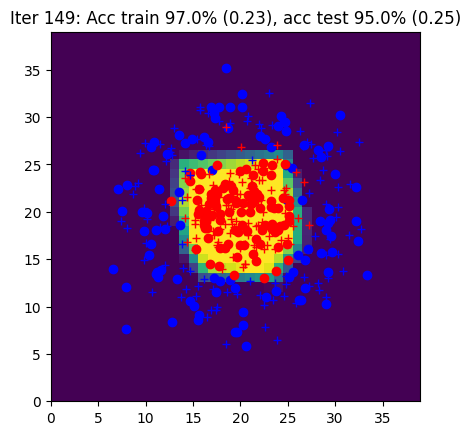

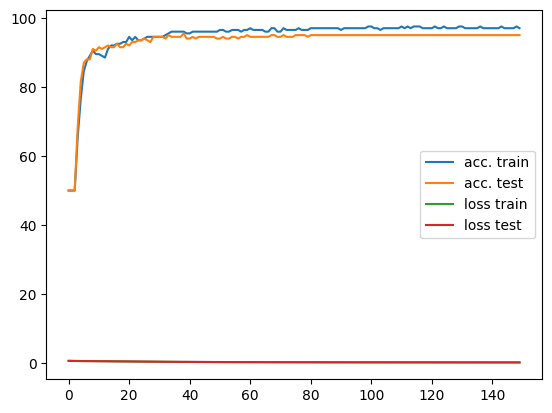

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd

         # simplified forward pass
        Yhat = model(X)

        # simplified loss
        L = loss(Yhat, Y)

        # backward pass
        L.backward()

        # step trought the gradient
        model = sgd(model, eta)

    ####################
    ##      END        #
    ####################


    Yhat_train = model(data.Xtrain)   #prof #finire
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    clear_output(wait=True)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 4 : Simplification of the SGD with `torch.optim`

In [ ]:
def init_model(nx, nh, ny, eta):

    #####################
    ## Your code here  ##
    #####################
    model = torch.nn.Sequential(
    torch.nn.Linear(nx, nh),
    torch.nn.ReLU(),
    torch.nn.Linear(nh, ny),
    torch.nn.Softmax()
    )

    loss = torch.nn.CrossEntropyLoss()

    optim = torch.optim.SGD(params=model.parameters(), lr=eta)

    ####################
    ##      END        #
    ####################

    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

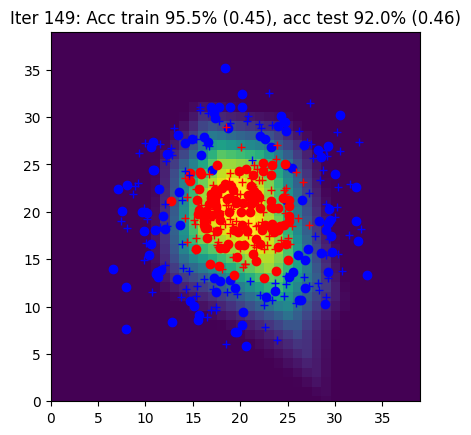

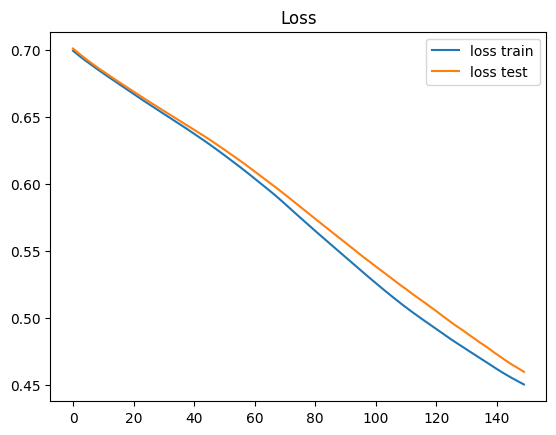

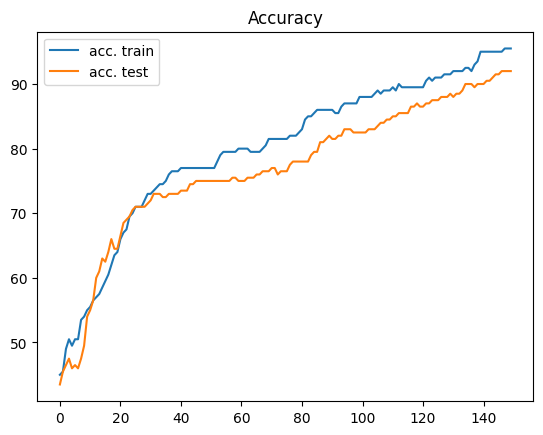

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step

        # forward pass
        Yhat = model(X)

        # calculate the loss
        L = loss(Yhat, Y)

        # optimizer zero grad
        optim.zero_grad()

        # loss backward
        L.backward()

        # optimizer step
        optim.step()

    ####################
    ##      FIN        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    clear_output(wait=True)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

# Initialization
fig_loss = plt.figure()
fig_accuracy = plt.figure()


ax1 = fig_loss.add_subplot(111)
ax2 = fig_accuracy.add_subplot(111)

# plot the two losses
ax1.plot(curves[2], label="loss train")
ax1.plot(curves[3], label="loss test")
ax1.set_title("Loss")
ax1.legend()

# plot the accuracies
ax2.plot(curves[0], label="acc. train")
ax2.plot(curves[1], label="acc. test")
ax2.set_title("Accuracy")
ax2.legend()


plt.show()

# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

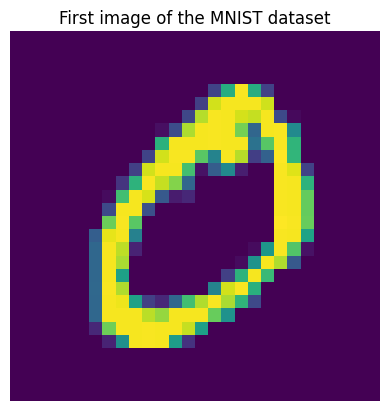

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03                          ##### PROVA A MODIFICARE ETA (LEARNING RATE) PER VEDERE SE CAMBIA LA CONFUSION MATRIX

image_test = data.Xtrain[0]

plt.figure()
plt.title("First image of the MNIST dataset")
plt.imshow(image_test.reshape(28,28))
plt.axis(False);

100%|██████████| 150/150 [05:50<00:00,  2.34s/it]


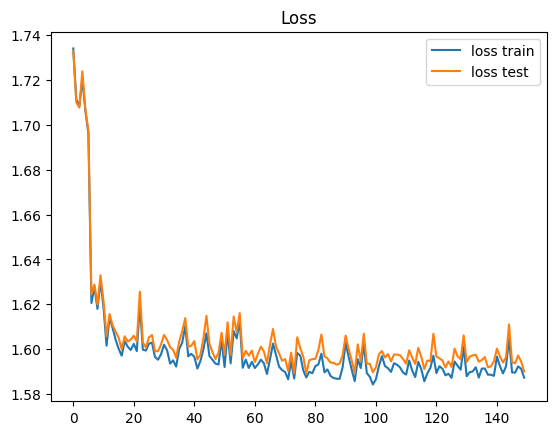

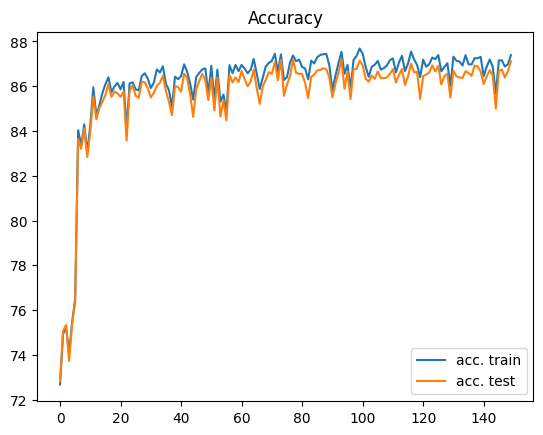

In [ ]:
from tqdm import tqdm

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in tqdm(range(150)):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        optim.zero_grad()

        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()

        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    #print(title)
    # data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

# Initialization
fig_loss = plt.figure()
fig_accuracy = plt.figure()


ax1 = fig_loss.add_subplot(111)
ax2 = fig_accuracy.add_subplot(111)

# plot the two losses
ax1.plot(curves[2], label="loss train")
ax1.plot(curves[3], label="loss test")
ax1.set_title("Loss")
ax1.legend()

# plot the accuracies
ax2.plot(curves[0], label="acc. train")
ax2.plot(curves[1], label="acc. test")
ax2.set_title("Accuracy")
ax2.legend()


plt.show()

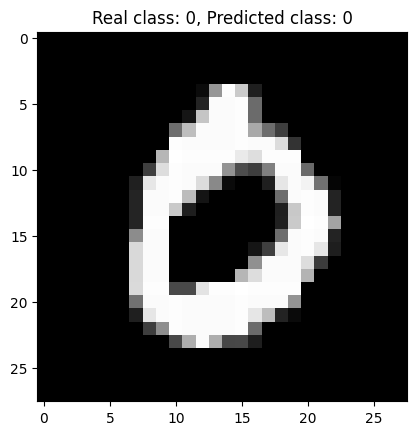

In [ ]:
plt.imshow(data.Xtest[0].reshape((28, 28)), cmap="gray")
plt.title(f"Real class: {data.Ytest[0].argmax()}, Predicted class: {Yhat_test[0].argmax()}")
plt.show()

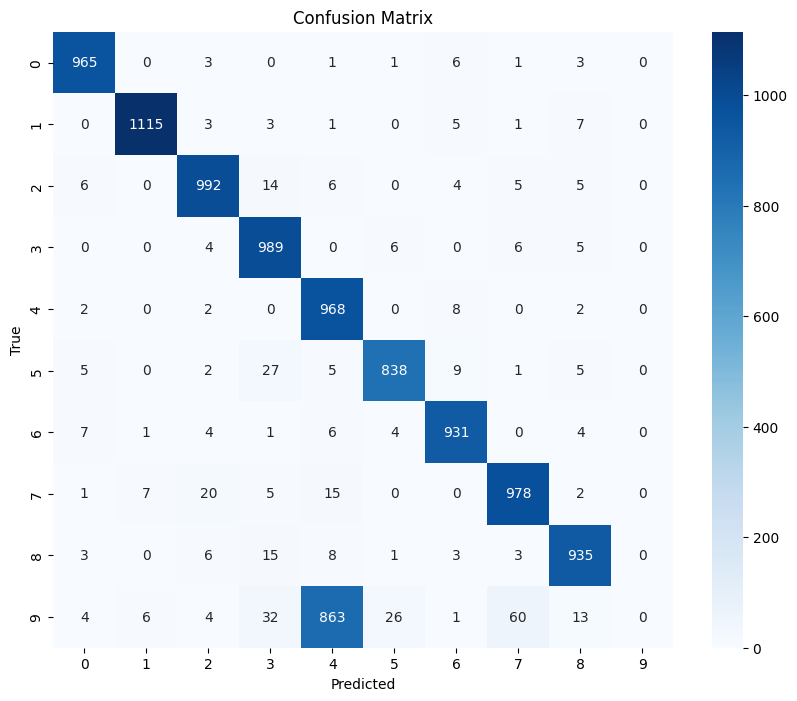

In [ ]:
confusion = confusion_matrix(data.Ytest.argmax(dim=1), Yhat_test.detach().argmax(dim=1))

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

# List of learning rates to experiment with
learning_rates = [0,0.01, 0.1, 0.5,1]

# Call the optimization function
optimize_learning_rates(learning_rates)

Linar SVM

In [ ]:
from sklearn.svm import LinearSVC

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = LinearSVC(dual=False)
svm.fit(Xtrain,Ytrain)

###########################

LinearSVC(dual=False)

Accuracy : 53.00


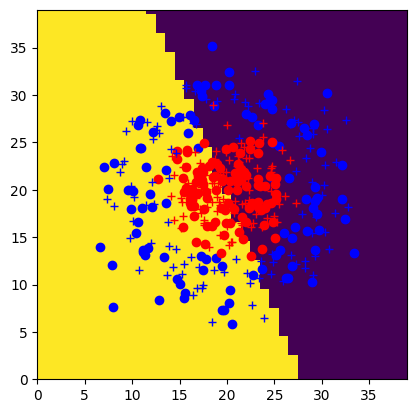

In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)

Complex kernels

poly SVM Accuracy: 54.50%


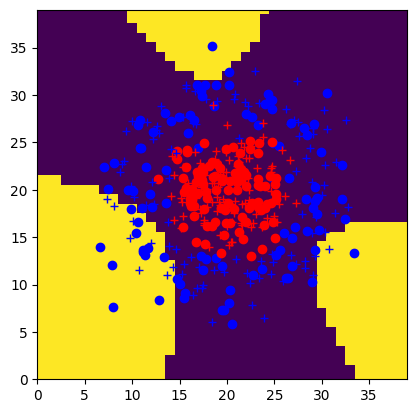

rbf SVM Accuracy: 94.00%


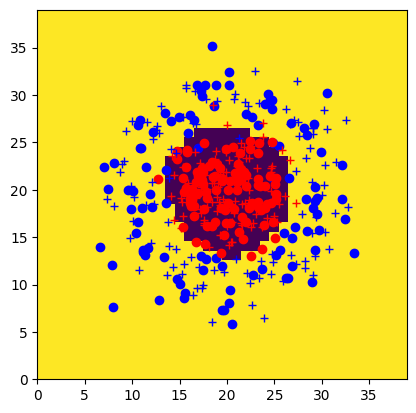

sigmoid SVM Accuracy: 65.00%


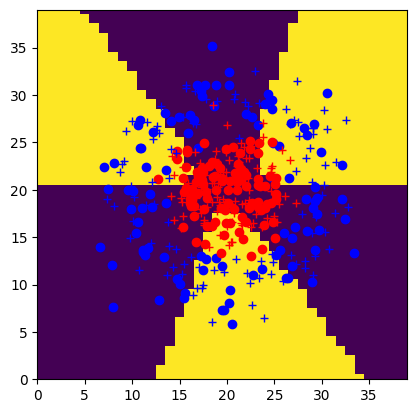

In [ ]:
kernels = ["poly","rbf","sigmoid"]
acc = {}

for k in kernels :
  clf = SVC(kernel = k)
  clf.fit(Xtrain, Ytrain)
  y_hat = clf.predict(Xtest)
  acc[k] = accuracy_score(Ytest, y_hat)
  print(f"{k} SVM Accuracy: {100 * acc[k]:.2f}%")

  plot_svm_predictions(data,clf.predict(Xgrid))


**The parameter C of regulation **

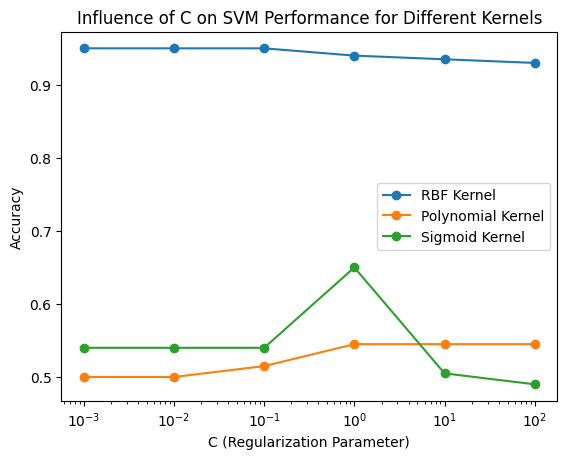

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

accuracy_results_rbf = []
accuracy_results_poly = []
accuracy_results_sigmoid = []

# Experiment with different C values for each kernel
for C in C_values:
    rbf_svm = SVC(kernel='rbf', C=C)
    rbf_svm.fit(Xtrain, Ytrain)
    y_pred = rbf_svm.predict(Xtest)
    accuracy_rbf = accuracy_score(Ytest, y_pred)
    accuracy_results_rbf.append(accuracy_rbf)

    poly_svm = SVC(kernel='poly', C=C)
    poly_svm.fit(Xtrain, Ytrain)
    y_pred = poly_svm.predict(Xtest)
    accuracy_poly = accuracy_score(Ytest, y_pred)
    accuracy_results_poly.append(accuracy_poly)

    sigmoid_svm = SVC(kernel='sigmoid', C=C)
    sigmoid_svm.fit(Xtrain, Ytrain)
    y_pred = sigmoid_svm.predict(Xtest)
    accuracy_sigmoid = accuracy_score(Ytest, y_pred)
    accuracy_results_sigmoid.append(accuracy_sigmoid)

# Plot the results for each kernel
plt.plot(C_values, accuracy_results_rbf, label='RBF Kernel', marker='o')
plt.plot(C_values, accuracy_results_poly, label='Polynomial Kernel', marker='o')
plt.plot(C_values, accuracy_results_sigmoid, label='Sigmoid Kernel', marker='o')

plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Influence of C on SVM Performance for Different Kernels')
plt.legend()
plt.show()